In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import cv2
import numpy as np
from corners import *
import random

In [2]:
def loadImages():
    images = []
    for i in range(1,11):
        location = r"imgs/%d.jpg"%i
        img = rgb2gray(mpl.image.imread(location))
        images.append(img)
    return images

In [3]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

In [4]:
def getFeaturePoints(img, winSize=21):
    result = cornerDetect(img, winSize, k=0.04, thd=1e14, type=1)
    # Non maximum suppression
    tempScale = np.pad(result, 2, mode='constant')
    width, height = tempScale.shape
    for x in range(2, width-2):
        for y in range(2, height-2):
            if tempScale[x][y] != np.max(tempScale[x-2:x+3, y-2:y+3]):
                tempScale[x][y] = 0
    result = tempScale[2:width-2, 2:height-2]
    y, x = np.nonzero(result)
    print('Number of corner : %d'%y.shape)
    plt.imshow(img,cmap='gray')
    plt.scatter(x, y, 50, marker='x', alpha = 0.3,color='r')
    plt.title('getFeaturePoints')
    plt.axis('off')
    plt.show()
    return x,y

In [5]:
def getFeatureDescriptors(X, Y, winSize, img):
    neighbors = []
    descriptors = []
    newPoint = []
    for x, y in zip(X,Y):
        patch_center = np.array([x, y])
        image = np.array(img)
        patch_size = winSize
        patch_x = int(patch_center[1] - patch_size / 2.)
        patch_y = int(patch_center[0] - patch_size / 2.)
        if patch_x < 0 or patch_y < 0:
            continue
        else:
            patch_image = image[patch_x:patch_x+patch_size, patch_y:patch_y+patch_size]
            patch_image = patch_image.astype(np.uint8)
            neighbors.append(patch_image.flatten())
            newPoint.append([x,y])
    return np.array(newPoint), np.array(neighbors)

In [6]:
def match2Images(desc1, keypoint1, desc2, keypoint2, type='ncc', thd = 2, verbose=False):
    dist = []
    keypoints = []
    
    for des1, key1 in zip(desc1, keypoint1):
        for des2, key2 in zip(desc2, keypoint2):
            if type == 'ncc':
                des1Norm = des1 / np.sqrt((np.sum(des1**2)))
                des2Norm = des2 / np.sqrt((np.sum(des2**2)))
                distance = np.dot(des1Norm.T,des2Norm)
                dist.append(distance)
                keypoints.append((key1, key2))
            elif type == 'euclidean':
                dist.append(np.sqrt(np.sum((des1-des2)**2)))
                keypoints.append((key1, key2))
            else:
                print('type error : use [ncc] or [euclidean]')
                
    dist = np.array(dist)
    keypoints = np.array(keypoints)
    if type == 'ncc':
        print('#ncc# min : %0.0f, max : %0.0f'%(min(dist),max(dist)))
        temp = dist < thd
        idxOfCorrectMatching = np.nonzero(temp)
    elif type == 'euclidean':
        print('#euclidean#  min : %0.0f, max : %0.0f'%(min(dist),max(dist)))
        temp = dist < thd
        idxOfCorrectMatching = np.nonzero(temp)
    else:
        print('type error : use [ncc] or [euclidean]')
        
    candidateCorrespondences = []
    for i in idxOfCorrectMatching:
        candidateCorrespondences.append(keypoints[i])
    candidate = np.array(candidateCorrespondences).reshape(len(candidateCorrespondences[0]),2,2)
    print('find %d matches'%len(candidate))
    return candidate

In [7]:
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h

In [8]:
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/(estimatep2.item(2) + 1e-8))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [9]:
def ransac(corr, thresh, verbose=False):
    maxInliers = []
    min_residual = -99999
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []
        
        residual = 0
        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            residual = residual + d
            if d < thresh:
                inliers.append(corr[i])
            
        avg_residual = residual / len(corr)

        if len(inliers) > len(maxInliers):
            finalH = h
            maxInliers = inliers
        
        if verbose:
            print("step: ", i, " average residual: ", avg_residual, " NumInliers: ", len(inliers))
        
    return finalH, maxInliers

In [10]:
def refineMatches(img1, img2, candidate, verbose=False):
    img1X_candi = candidate[:,:1,:1].reshape(len(candidate))
    img1Y_candi = candidate[:,:1,1:].reshape(len(candidate))
    img2X_candi = candidate[:,1:,:1].reshape(len(candidate))
    img2Y_candi = candidate[:,1:,1:].reshape(len(candidate))
    
    if verbose:
        fig = plt.figure()
        ax1 = fig.add_subplot(1,2,1)
        ax2 = fig.add_subplot(1,2,2)
        ax1.imshow(img1, cmap='gray')
        ax2.imshow(img2, cmap='gray')
        for x1, y1, x2, y2 in zip(img1X_candi, img1Y_candi, img2X_candi, img2Y_candi):
            ax1.scatter(x1, y1, marker='x')
            ax2.scatter(x2, y2, marker='x')
        ax1.axis('off')
        ax2.axis('off')
        plt.show()
        
    correspondenceList = []
    for x1, y1, x2, y2 in zip(img1X_candi,img1Y_candi, img2X_candi,img2Y_candi):
        correspondenceList.append([x2, y2, x1, y1])
    corrs = np.matrix(correspondenceList)
    inlier_thresh = 10
    finalH, inliers = ransac(corrs, inlier_thresh, False)
    inliers = np.array(inliers).reshape(-1, 4)
    
    plt.show()
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.imshow(img1, cmap='gray')
    ax2.imshow(img2, cmap='gray')
    for x1, y1, x2, y2 in zip(inliers[:, 0], inliers[:, 1], inliers[:, 2], inliers[:, 3]):
        ax1.scatter(x1, y1, marker='x')
        ax2.scatter(x2, y2, marker='x')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    return finalH, inliers

In [11]:
def warpImages(img1, img2, finalH, verbose=False):
    height, width = img1.shape
    height1, width1 = img2.shape
    warppedImage = cv2.warpPerspective(img2,finalH,(width+width1, height))
    plt.imshow(warppedImage,cmap='gray')
    plt.title('Warped Imag')
    plt.axis('off')
    plt.show()
    plt.figure()
    
    warppedImage[0:img1.shape[0], 0:img1.shape[1]] = img1
    if verbose:
        plt.imshow(warppedImage,cmap='gray')
        plt.axis('off')
        plt.show()
    
    res = trim(warppedImage)
    plt.figure()
    plt.imshow(res,cmap='gray')
    plt.axis('off')
    plt.show()
    
    return res

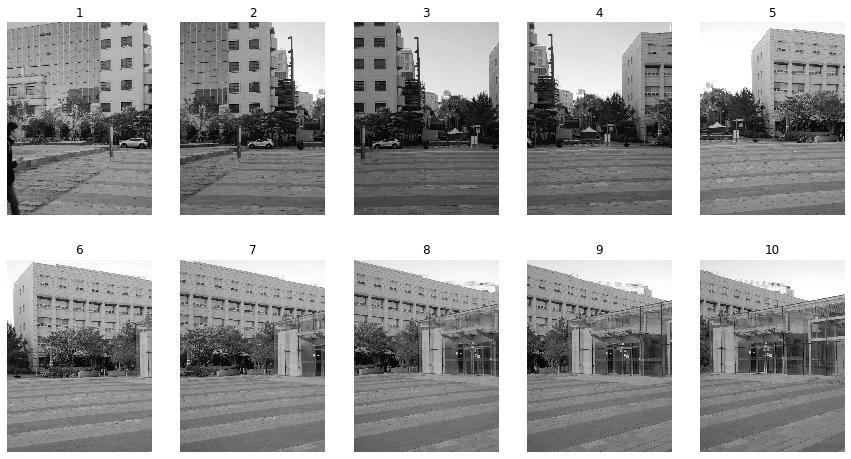

In [12]:
images = loadImages()
fig = plt.figure(figsize=(15,8))
for idx in range(10):
    ax = fig.add_subplot(2,5,idx+1)
    ax.imshow(images[idx], cmap='gray')
    ax.axis('off')
    cmd = str(idx+1)
    ax.set_title(cmd)
plt.show()    

각 이미지의 코너를 DETECT한다.
이미지 마다 DETECT된 코너좌표를 리스트로 저장 imgX[0~9], imgY[0~9]
# 10장 다 해야해서 오래걸림;;

Number of corner : 2474


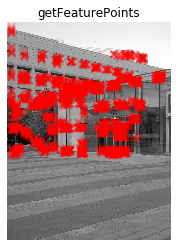

Number of corner : 2405


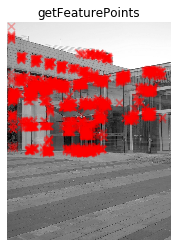

#euclidean#  min : 119, max : 384
find 30 matches


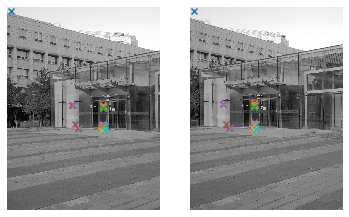

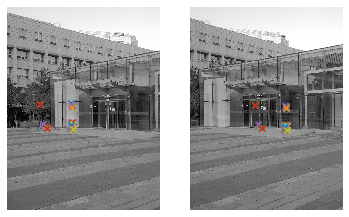

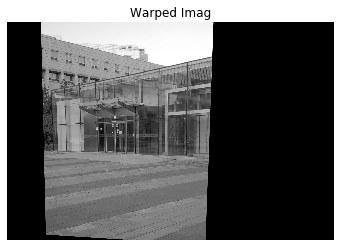

<Figure size 432x288 with 0 Axes>

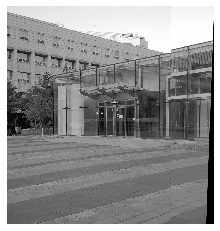

Number of corner : 1684


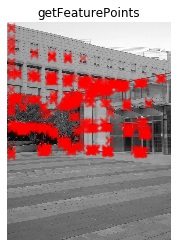

Number of corner : 2666


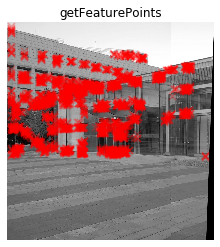

#euclidean#  min : 148, max : 382
find 67 matches


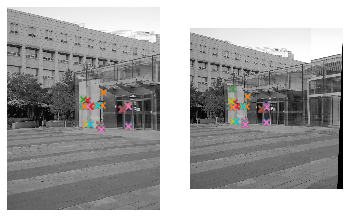

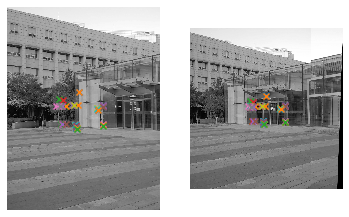

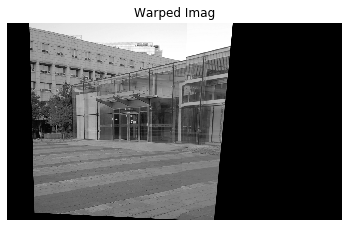

<Figure size 432x288 with 0 Axes>

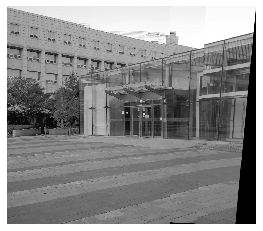

Number of corner : 2816


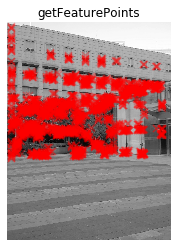

Number of corner : 1868


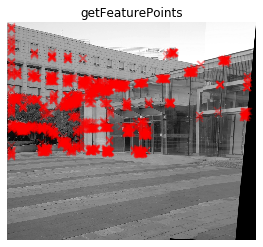

#euclidean#  min : 146, max : 395
find 21 matches


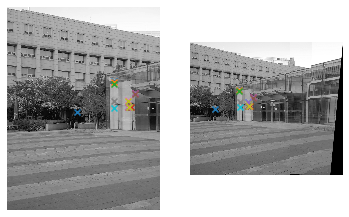

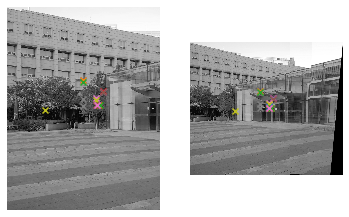

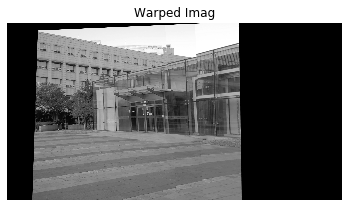

<Figure size 432x288 with 0 Axes>

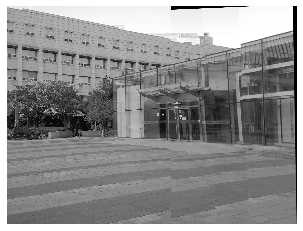

In [13]:
winSizes = [0, 0, 0, 0, 0, 35, 35, 33, 33]
matchThds = [0, 0, 0, 0, 0, 220, 195, 200, 170]

imgLeft = images[8]
imgRight = images[9]
time.sleep(3)
for i in range(8):    
    rIdx = 8 - i
    #print('{} => img1: {}, img2: {} ({}, {})\n'.format(rIdx, imgLeft.shape, imgRight.shape, winSizes[rIdx], matchThds[rIdx]))
    
    if rIdx == 7:
        break;
    imgX0, imgY0 = getFeaturePoints(imgLeft, 40)
    imgX1, imgY1 = getFeaturePoints(imgRight, 40)    
    time.sleep(3)
    
    keypoint0, desc0 = getFeatureDescriptors(imgX0, imgY0, winSizes[rIdx], imgLeft)
    keypoint1, desc1 = getFeatureDescriptors(imgX1, imgY1, winSizes[rIdx], imgRight)
    time.sleep(3)
    
    candidate = match2Images(desc0, keypoint0, desc1, keypoint1,'euclidean', matchThds[rIdx])    
    time.sleep(3)
    
    finalH, inliers = refineMatches(imgLeft, imgRight, candidate, True)
    resImg = warpImages(imgLeft, imgRight, finalH, False)
    time.sleep(3)
    
    imgLeft = images[rIdx-1]
    imgRight = resImg
    time.sleep(3)

img1: (1066, 800), img2: (1066, 1418)

Number of corner : 2575


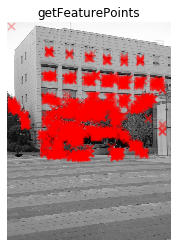

Number of corner : 3028


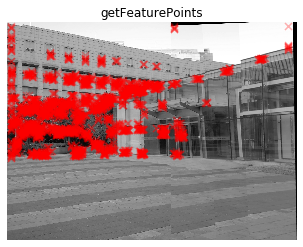

#euclidean#  min : 126, max : 413
find 9 matches


In [14]:
imgLeft = images[5]
imgRight = resImg
print('img1: {}, img2: {}\n'.format(imgLeft.shape, imgRight.shape))
imgX0, imgY0 = getFeaturePoints(imgLeft, 40)
imgX1, imgY1 = getFeaturePoints(imgRight, 40)

In [18]:
keypoint0, desc0 = getFeatureDescriptors(imgX0, imgY0, 32, imgLeft)
keypoint1, desc1 = getFeatureDescriptors(imgX1, imgY1, 32, imgRight)

candidate = match2Images(desc0, keypoint0, desc1, keypoint1,'euclidean', 190)

#euclidean#  min : 75, max : 383
find 24 matches


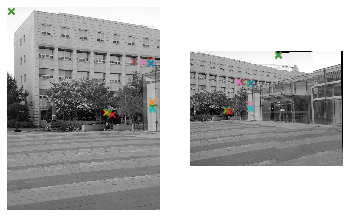

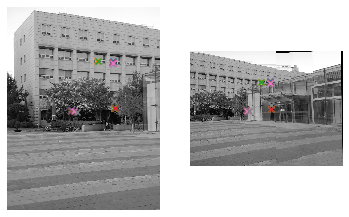

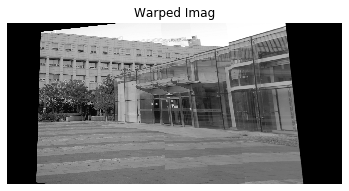

<Figure size 432x288 with 0 Axes>

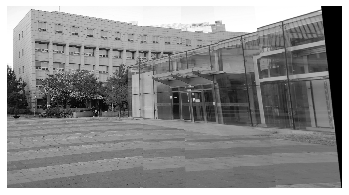

In [19]:
finalH, inliers = refineMatches(imgLeft, imgRight, candidate, True)
resImg1 = warpImages(imgLeft, imgRight, finalH, False)

img1: (1066, 800), img2: (1066, 1966)

Number of corner : 2265


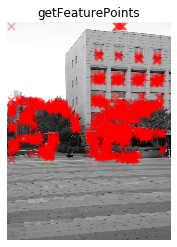

Number of corner : 2922


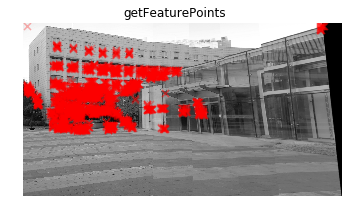

In [20]:
imgLeft = images[4]
imgRight = resImg1
print('img1: {}, img2: {}\n'.format(imgLeft.shape, imgRight.shape))
imgX0, imgY0 = getFeaturePoints(imgLeft, 40)
imgX1, imgY1 = getFeaturePoints(imgRight, 40)

In [21]:
keypoint0, desc0 = getFeatureDescriptors(imgX0, imgY0, 32, imgLeft)
keypoint1, desc1 = getFeatureDescriptors(imgX1, imgY1, 32, imgRight)

candidate = match2Images(desc0, keypoint0, desc1, keypoint1,'euclidean', 190)

#euclidean#  min : 144, max : 387
find 19 matches


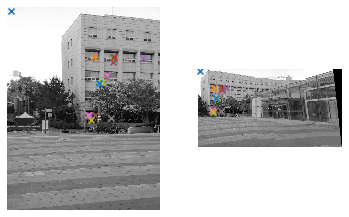

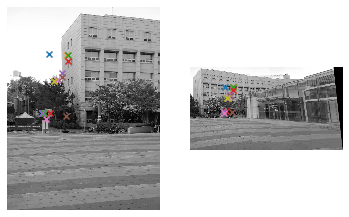

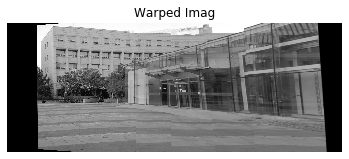

<Figure size 432x288 with 0 Axes>

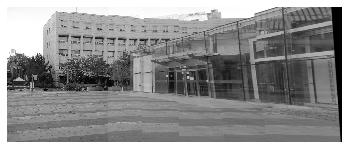

In [22]:
finalH, inliers = refineMatches(imgLeft, imgRight, candidate, True)
resImg2 = warpImages(imgLeft, imgRight, finalH, False)

img1: (1066, 800), img2: (1066, 2650)

Number of corner : 2668


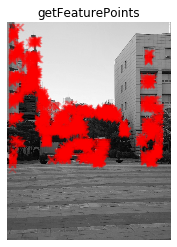

Number of corner : 2746


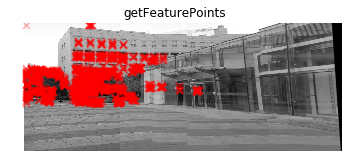

In [57]:
imgLeft = images[3]
imgRight = resImg2
print('img1: {}, img2: {}\n'.format(imgLeft.shape, imgRight.shape))
imgX0, imgY0 = getFeaturePoints(imgLeft, 50)
imgX1, imgY1 = getFeaturePoints(imgRight, 40)

In [ ]:
keypoint0, desc0 = getFeatureDescriptors(imgX0, imgY0, 100, imgLeft)
keypoint1, desc1 = getFeatureDescriptors(imgX1, imgY1, 100, imgRight)

candidate = match2Images(desc0, keypoint0, desc1, keypoint1,'euclidean', 915)

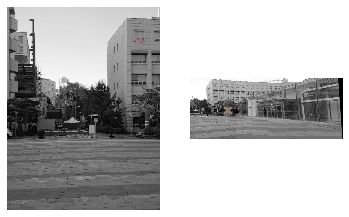

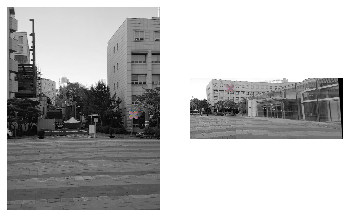

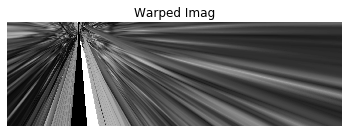

<Figure size 432x288 with 0 Axes>

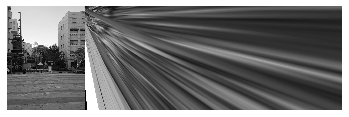

In [76]:
finalH, inliers = refineMatches(imgLeft, imgRight, candidate, True)
resImg3 = warpImages(imgLeft, imgRight, finalH, False)

### * Conclusion
#### We try so many times but when image has many bushes, it can't match other image. 
#### Our best image's sum number is 6.
#### Upper 7 is not good result. See below.(try from 40 to 100 path size)

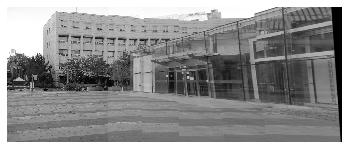

In [67]:
# 6 images (Good)
plt.figure()
plt.imshow(resImg2,cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# 7 images...... (bad)
plt.figure()
plt.imshow(resImg3,cmap='gray')
plt.axis('off')
plt.show()